In [17]:
from pathlib import Path
import numpy as np
import rasterio as rio
from matplotlib import colormaps, pyplot as plt

from topex import Topex
from utils import find_raster_resolution

In [39]:
work_dir = Path().cwd().parent
dem_path = work_dir / 'data/LX_DEM_50m_res.tif'
src = rio.open(dem_path)
dem = src.read(1)
profile = src.profile
y_res, x_res = find_raster_resolution(src)
# If DEM contains sea, and land area doesn't have 0m values, we can use this
# masking to remove topex artefacts on the water areas
land_mask = dem==0.
sea_mask = ~land_mask * 1.
sea_mask[sea_mask==0] = np.nan

In [5]:
interval = 100
max_dist = 2000

topex = Topex(dem, max_dist, interval, y_res=y_res, x_res=x_res)
topex_all = topex.all_dir_multip() # multiproc w/o shared_memory

In [6]:
topex = Topex(dem, max_dist, interval, y_res=y_res, x_res=x_res)
topex_se = topex.south_east()

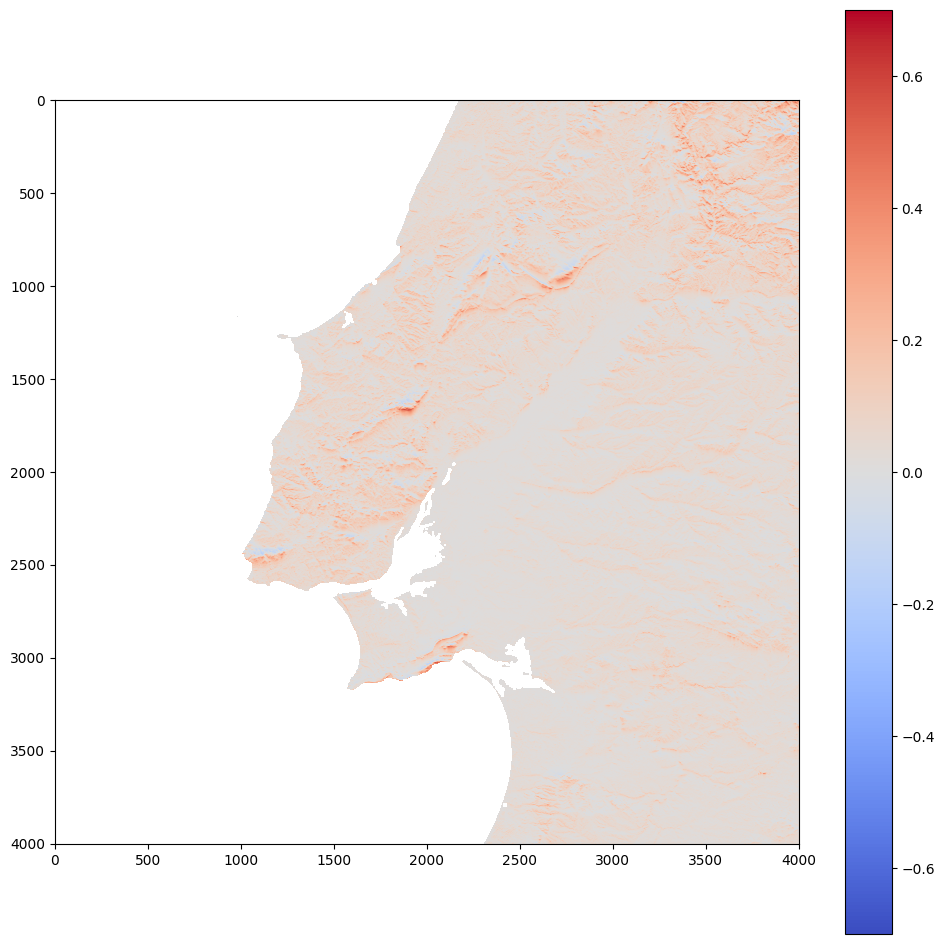

In [47]:
plt.figure(figsize=(12,12))
plt.imshow(topex_all[0]*sea_mask, vmin=-0.7, vmax=0.7, cmap=colormaps['coolwarm'])
plt.colorbar()

In [6]:
# Write each TOPEX map in a separate .tif file
topex_name = ['TOPEX_N', 'TOPEX_NE', 'TOPEX_E', 'TOPEX_SE', 'TOPEX_S', 'TOPEX_SW', 'TOPEX_W', 'TOPEX_NW']
profile.update(dtype=rio.float32, count=1)

for topex, name in zip(topex_all, topex_name):
    with rio.open(work_dir / 'results' / f'{name}.tif', 'w', **profile) as dest:
        topex *= sea_mask # Apply sea mask to clean the artifacts
        dest.write(topex, 1)

In [15]:
# Write each TOPEX map in a separate .tif file
profile.update(dtype=rio.float32, count=1)
name = 'topex_SE_brick'
with rio.open(work_dir / 'results/brick' / f'{name}_brick.tif', 'w', **profile) as dest:
    topex_se *= sea_mask # Apply sea mask to clean the artifacts
    dest.write(topex_se, 1)